In [1]:
from aberrations import make_atm_data, make_1D_vibe_data, make_vibe_params
from observer import make_state_transition_vibe, make_kfilter_vibe, KFilter, make_impulse_from_tt, make_kfilter_turb
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, linalg
from copy import deepcopy
%matplotlib inline

f_sampling = 1000
N_vibe = 0
use_turb = True
steps = 5000
noise = 0.06
delay = 1

rms = lambda data: np.sqrt(np.mean(data ** 2))

In [2]:
if use_turb:
    turb = make_atm_data(steps)[:,0]

In [3]:
true_vibes = np.zeros((N_vibe, steps))
vibe_errs = np.zeros((N_vibe, steps))
vibe_params = np.zeros((N_vibe, 4))
# let's add in process noise so that there's something for Q to fit to!
process_vars = (10**-np.random.uniform(2, 3, (N_vibe,)))**2

In [4]:
process_vars

array([], dtype=float64)

In [5]:
for i in range(N_vibe):
    pars = make_vibe_params(N=1)
    true_vibes[i] = make_1D_vibe_data(steps, vib_params=pars, N=1)
    vibe_errs[i] = np.random.normal(0, process_vars[i], (steps,))
    vibe_params[i] = pars
    
vibes = true_vibes + vibe_errs

In [6]:
if use_turb:
    truths = np.sum(vibes, axis=0) + turb
else:
    truths = np.sum(vibes, axis=0)
    
measurements = truths + np.random.normal(0, noise, (truths.size,))

(1e-07, 9.988291944796444)

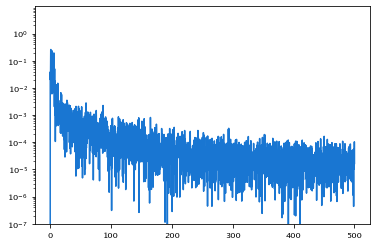

In [7]:
plt.semilogy(*signal.periodogram(truths, fs=f_sampling))
plt.ylim(1e-7)

Took 0 iterations to get steady-state covariance.
Took 28 iterations to get steady-state covariance.


/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


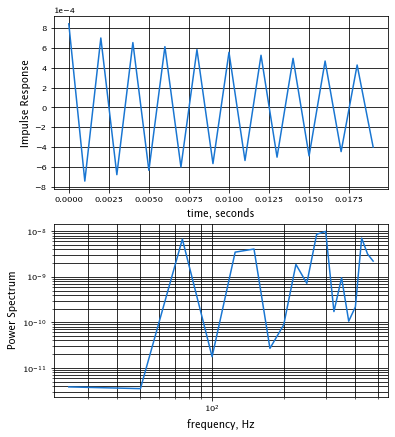

In [8]:
kfilter_v = make_kfilter_vibe(vibe_params[:,1:3], process_vars)
kfilter_t = make_kfilter_turb(make_impulse_from_tt(truths[:500] + np.random.normal(0, 0.06, (500,))))
kfilter_t.iters = max(kfilter_t.iters, 500)

In [9]:
kfilter = kfilter_v + kfilter_t

In [10]:
# something seems very wrong with my control code, so I'm just ditching it.

actions = np.zeros(steps - kfilter.iters,)
for i in range(kfilter.iters, steps - 1):
    kfilter.update(measurements[i])
    actions[i - kfilter.iters + delay] = kfilter.H.dot((kfilter.A**(delay)).dot(kfilter.state))
    kfilter.predict()

In [11]:
print(rms(measurements))
print(rms(actions - truths[kfilter.iters:]))

0.8002879303784367
1.2967108742940927


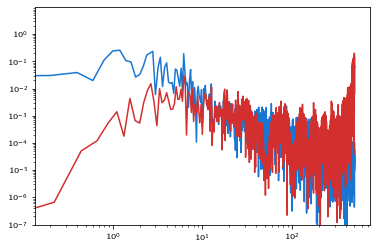

In [14]:
ft, Pt = signal.periodogram(truths, fs=f_sampling)
fres, Pres = signal.periodogram(truths[kfilter.iters:] - actions, fs=f_sampling)
plt.loglog(ft, Pt)
plt.loglog(fres, Pres)
plt.ylim(1e-7)
plt.show()